In [122]:
import pandas as pd
from tqdm import tqdm
import pickle
import numpy as np
import statsmodels.api as sm
import os 
#时间
import datetime

#算法辅助&数据
from sklearn.model_selection import KFold,cross_validate   #交叉验证
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.model_selection import train_test_split     #训练集测试集拆分

#算法（单一学习器）                          
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier   
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC

#融合模型
from sklearn.ensemble import VotingClassifier

# 关闭警告
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger().setLevel(logging.ERROR)

### 1 数据导入

In [123]:
# 基准指数
index_item = '000300.XSHG'
file_path = './300/InformationTechnology'
# 机器学习数据
data = pd.read_pickle(os.path.join(file_path, 'data/ml_data.pkl')) #'./300/Financials/data/ml_data.pkl'
# 研究周期
date_list = sorted(set(data.index.get_level_values(0)))                                    # 研究周期确定
# 建立特征集                                         
data

pcf_ratio_ttm  pb_ratio_ttm  dividend_yield_ttm  \
date       order_book_id                                                    
2020-01-02 000063.XSHE         0.314275     -0.429960           -1.309979   
           000725.XSHE        -0.950808     -1.722351            0.254169   
           000938.XSHE         0.947946     -1.266856            0.033036   
           002153.XSHE         1.179284     -0.453378           -0.580557   
           002230.XSHE         0.096392      0.324068           -0.417191   
...                                 ...           ...                 ...   
2025-03-20 688303.XSHG        -0.448973     -0.188170            0.291411   
           688396.XSHG         0.242518     -0.855443           -0.619135   
           688472.XSHG         0.126854      0.170802           -0.883831   
           688599.XSHG        -0.075505     -0.055554            0.758048   
           688981.XSHG         0.295017     -0.429561           -1.098614   

                          diluted_earnings_per_share_ttm  ebit_per_share_ttm  \
date       order_book_id                                                       
2020-01-02 000063.XSHE                          0.203440            0.850061   
           000725.XSHE                         -1.525863           -1.507641   
           000938.XSHE                          0.503585            1.159291   
           002153.XSHE                         -0.138922           -0.038867   
           002230.XSHE                         -0.596210           -0.752513   
...                                                  ...                 ...   
2025-03-20 688303.XSHG                          0.096148            0.023756   
           688396.XSHG                         -0.362322           -0.340018   
           688472.XSHG                          0.775286            0.733857   
           688599.XSHG                          0.143985            0.637415   
           688981.XSHG                         -0.906362           -0.637333   

                          adjusted_profit_to_total_profit_ttm  \
date       order_book_id                                        
2020-01-02 000063.XSHE                              -1.355604   
           000725.XSHE                               0.632175   
           000938.XSHE                              -0.446399   
           002153.XSHE                               0.181263   
           002230.XSHE                              -0.384000   
...                                                       ...   
2025-03-20 688303.XSHG                              -1.790170   
           688396.XSHG                                    NaN   
           688472.XSHG                               1.732591   
           688599.XSHG                                    NaN   
           688981.XSHG                                    NaN   

                          fixed_asset_turnover_ttm  fcff_ttm  \
date       order_book_id                                       
2020-01-02 000063.XSHE                   -0.409979  0.674490   
           000725.XSHE                   -1.508904 -2.194085   
           000938.XSHE                    1.457682  0.931760   
           002153.XSHE                    0.534148 -0.034351   
           002230.XSHE                   -1.363776 -1.091795   
...                                            ...       ...   
2025-03-20 688303.XSHG                   -0.325894 -0.588424   
           688396.XSHG                   -0.984391 -0.657739   
           688472.XSHG                    0.365963  1.695992   
           688599.XSHG                    0.588161 -0.044563   
           688981.XSHG                   -1.933059 -2.465281   

                          ocf_to_net_debt_ttm  book_value_per_share_ttm  ...  \
date       order_book_id                                                 ...   
2020-01-02 000063.XSHE              -0.110803                  0.999427  ...   
           000725.XSHE              -0.066023                 -1

In [124]:
# 特征集
x = data.loc[:,:'surplus_reserve_ttm_0']                                                                   # 去除文本数据，保留因子数据
# 目标集合
y = data.loc[:,'target']                                                                   # Y对象为binary数据1，0
# 样本分离
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)         # 拆分训练集和测试集
# 特征名称
features = x_train.columns.tolist()          

In [125]:
# 目标集合
y = data.loc[:,'target']                                                                   # Y对象为binary数据1，0
# 样本分离
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)         # 拆分训练集和测试集
# 特征名称
features = x_train.columns.tolist()      

### 2 模型训练

#### randomforest

In [126]:
def best_estimetor_RandomForestClassifier(data_train_input,fatcors):
    precision_postive_cv_clf = pd.DataFrame()
    for j in tqdm(range(3,8,2)):
        for t in np.logspace(-8,-5,3):
            for z in range(int(np.sqrt(len(fatcors))),len(fatcors)-1,4):
                clf = RandomForestClassifier(n_estimators=10,
                                             criterion='gini',
                                             max_features= z,
                                             max_depth=j,
                                             class_weight='balanced',
                                             ccp_alpha=t,
                                             random_state = 0,
                                             n_jobs = -2)         #生成随机森林
                precision_postive_cv = 0
                for i in range(1,6):
                    data_train = data_train_input[data_train_input.label != i]
                    data_validation = data_train_input[data_train_input.label == i]
                    x_train = data_train.loc[:,fatcors]
                    y_train = data_train.loc[:,'target']
                    x_val = data_validation.loc[:,fatcors]
                    y_val = data_validation.loc[:,'target']
                    clf.fit(x_train,y_train)
                    y_hat = clf.predict(x_val)                                          # 训练模型
                    martrix = confusion_matrix(y_val, y_hat)
                    metric = martrix[1,1] / martrix[:,1].sum()                          # 精确率 预测是涨结果真的涨了
                    # metric = (martrix[1,1] + martrix[0,0]) / martrix.sum().sum()      # 准确率 预测是涨结果真的涨了
                    precision_postive_cv += metric
                temp = pd.DataFrame([j,t,z,precision_postive_cv/5],index = ['max_depth','ccp_alpha','max_features','precision_postive_cv'])
                precision_postive_cv_clf = pd.concat([precision_postive_cv_clf,temp],axis = 1)
    return precision_postive_cv_clf

In [127]:
pre_gap = 240 * 2        # 预计算
ret_gap = 5              # 预测收益
predict_gap = 60         # 预测长度

# 滚动周期
trade_days = sorted(list(set(data.index.get_level_values(0).tolist())))
re_train_days = trade_days[pre_gap::predict_gap]

all_trading_dates = pickle.load(open('trading_dates.pkl','rb'))

def get_trading_dates(start_date,end_date):
    #input date are timestamps
    start_date = start_date.date()
    end_date = end_date.date()
    trading_dates = []
    for date in all_trading_dates:
        if start_date <= date <= end_date:
            trading_dates.append(date)
    return trading_dates

In [128]:
def get_previous_trading_date(dt, gap):
    idx = all_trading_dates.index(pd.Timestamp(dt).date())
    return all_trading_dates[max(0, idx - gap)]

def get_next_trading_date(dt, gap):
    idx = all_trading_dates.index(pd.Timestamp(dt).date())
    return all_trading_dates[min(len(all_trading_dates) - 1, idx + gap)]

In [129]:
model_name = 'rf'
data_test_total = pd.DataFrame()

for i in tqdm(re_train_days):            # 测试5期
    # 训练开始/结束时间
    train_start = pd.Timestamp(get_previous_trading_date(i,(pre_gap + ret_gap)))
    train_end = pd.Timestamp(get_previous_trading_date(i,ret_gap))
    # 测试开始/结束时间
    test_start = i
    test_end = pd.Timestamp(get_next_trading_date(i,predict_gap - 1))
    # 训练集数据
    data_train = data.loc[train_start:train_end]
    data_train_x = data_train.loc[:,features]
    data_train_y = data_train.loc[:,'target']
    # 测试集数据
    data_test = data.loc[test_start:test_end]
    data_test_x = data_test.loc[:,features]
    
    # 打标记号_5fold_交叉验证
    date_len = sorted(set(data_train.index.get_level_values(0)))
    fold_length = (len(date_len) - 80)//5
    label = ([1] * fold_length 
            + [0] * 20 
            + [2] * fold_length 
            + [0] * 20 
            + [3] * fold_length 
            + [0] * 20 
            + [4] * fold_length 
            + [0] * 20 
            + [5] * (len(date_len) - 80 - (fold_length * 4))
            )
    for i,j in zip(date_len,label):
        data_train.loc[i,'label'] = j
    
    # 模型训练
    paramter = best_estimetor_RandomForestClassifier(data_train,features).T.sort_values(by ='precision_postive_cv',ascending = False).iloc[0].to_dict()
    print(i,paramter)
    # 模型输出
    clf = RandomForestClassifier(criterion = 'gini',
                                 max_depth = int(paramter['max_depth']),
                                 class_weight = 'balanced',
                                 ccp_alpha = paramter['ccp_alpha'],
                                 max_features = int(paramter['max_features']),
                                 random_state = 0,
                                 n_jobs = -2)

    # 预测结果输出
    y_hat = clf.fit(data_train_x,data_train_y).predict(data_test_x)
    data_test['predict'] = y_hat
    data_test_total = pd.concat([data_test_total,data_test[['predict']]],axis = 0)

data_test_total.to_pickle(os.path.join(file_path, f'data/data_test_total_{model_name}_all.pkl'))

100%|██████████| 3/3 [00:42<00:00, 14.28s/it]


2021-12-17 00:00:00 {'max_depth': 7.0, 'ccp_alpha': 1e-05, 'max_features': 13.0, 'precision_postive_cv': 0.4439172515718714}


100%|██████████| 3/3 [00:44<00:00, 14.86s/it]]


2022-03-21 00:00:00 {'max_depth': 7.0, 'ccp_alpha': 1e-05, 'max_features': 21.0, 'precision_postive_cv': 0.45367618112048486}


100%|██████████| 3/3 [00:46<00:00, 15.39s/it]]


2022-06-21 00:00:00 {'max_depth': 7.0, 'ccp_alpha': 1e-08, 'max_features': 17.0, 'precision_postive_cv': 0.4569946870637347}


100%|██████████| 3/3 [00:49<00:00, 16.64s/it]]


2022-09-14 00:00:00 {'max_depth': 5.0, 'ccp_alpha': 3.162277660168379e-07, 'max_features': 17.0, 'precision_postive_cv': 0.461297352871538}


100%|██████████| 3/3 [00:52<00:00, 17.56s/it]]


2022-12-14 00:00:00 {'max_depth': 5.0, 'ccp_alpha': 3.162277660168379e-07, 'max_features': 13.0, 'precision_postive_cv': 0.4632434775143695}


100%|██████████| 3/3 [00:54<00:00, 18.19s/it]]


2023-03-16 00:00:00 {'max_depth': 7.0, 'ccp_alpha': 1e-05, 'max_features': 13.0, 'precision_postive_cv': 0.45261337630548343}


100%|██████████| 3/3 [00:54<00:00, 18.07s/it]]


2023-06-14 00:00:00 {'max_depth': 5.0, 'ccp_alpha': 1e-05, 'max_features': 5.0, 'precision_postive_cv': 0.45819321355566284}


100%|██████████| 3/3 [00:55<00:00, 18.57s/it]]


2023-09-08 00:00:00 {'max_depth': 7.0, 'ccp_alpha': 1e-05, 'max_features': 9.0, 'precision_postive_cv': 0.4625765270249218}


100%|██████████| 3/3 [01:00<00:00, 20.05s/it]]


2023-12-11 00:00:00 {'max_depth': 5.0, 'ccp_alpha': 1e-05, 'max_features': 9.0, 'precision_postive_cv': 0.4655774170724497}


100%|██████████| 3/3 [01:07<00:00, 22.64s/it]]


2024-03-13 00:00:00 {'max_depth': 7.0, 'ccp_alpha': 1e-05, 'max_features': 21.0, 'precision_postive_cv': 0.47093171079788565}


100%|██████████| 3/3 [01:09<00:00, 23.07s/it]t]


2024-06-13 00:00:00 {'max_depth': 7.0, 'ccp_alpha': 1e-05, 'max_features': 21.0, 'precision_postive_cv': 0.48398616402746103}


100%|██████████| 3/3 [01:06<00:00, 22.23s/it]t]


2024-09-05 00:00:00 {'max_depth': 7.0, 'ccp_alpha': 1e-05, 'max_features': 21.0, 'precision_postive_cv': 0.4774863413453878}


100%|██████████| 3/3 [01:04<00:00, 21.63s/it]t]


2024-12-09 00:00:00 {'max_depth': 7.0, 'ccp_alpha': 1e-08, 'max_features': 5.0, 'precision_postive_cv': 0.49445493301796783}


100%|██████████| 3/3 [01:04<00:00, 21.42s/it]t]


2025-03-12 00:00:00 {'max_depth': 5.0, 'ccp_alpha': 3.162277660168379e-07, 'max_features': 17.0, 'precision_postive_cv': 0.4796426165856049}


100%|██████████| 14/14 [13:59<00:00, 59.97s/it]


In [130]:
model_name = 'rf'
data_test_total = pd.read_pickle(os.path.join(file_path, f'data/data_test_total_{model_name}_all.pkl'))

In [131]:
def get_siganl_delay(x_test,T = 5):
    # 时间获取
    start_date = x_test.index.get_level_values(0).min()
    end_date = x_test.index.get_level_values(0).max()
    date_list = pd.to_datetime(get_trading_dates(start_date,end_date))
    # 信号数字化
    predict_signal = x_test['predict'].astype(int)
    # 信号递延
    predict_signal = predict_signal.unstack().fillna(0).reindex(date_list).unstack()
    predict_signal_delay = pd.DataFrame({i:predict_signal.groupby(level=0).apply(lambda x:x.shift(i)).droplevel(0) for i in range(1,T+1)}).sort_index()
    # 信号叠加
    predict_signal_delay['signal_level'] = predict_signal_delay.sum(axis = 1) 
    predict_signal_cum = predict_signal_delay.signal_level.unstack('order_book_id')
    # predict_signal_cum.stack().replace(0,np.nan).hist(bins = 5)
    # predict_signal_cum.stack().value_counts().sort_index()

    return predict_signal_cum,predict_signal_delay

100%|██████████| 156/156 [00:00<00:00, 703.07it/s]


{'策略累计收益': np.float64(-0.0674),
 '策略年化收益': np.float64(-0.0223),
 '基准累计收益': np.float64(-0.1902),
 '基准年化收益': np.float64(-0.0658),
 '阿尔法': np.float64(0.0772),
 '贝塔': np.float64(1.1613),
 '波动率': np.float64(0.2982),
 '夏普比率': np.float64(-0.1752),
 '下行波动率': np.float64(0.1561),
 '索提诺比率': np.float64(-0.3347),
 '跟踪误差': np.float64(0.1766),
 '信息比率': np.float64(0.2466),
 '最大回撤': np.float64(0.4156),
 '卡玛比率': np.float64(-0.0536),
 '超额累计收益': np.float64(0.1516),
 '超额年化收益': np.float64(0.0466),
 '超额波动率': np.float64(0.1755),
 '超额夏普': np.float64(0.0946),
 '超额最大回测': np.float64(0.2204),
 '胜率': np.float64(0.5013),
 '盈亏比': np.float64(1.0534)}

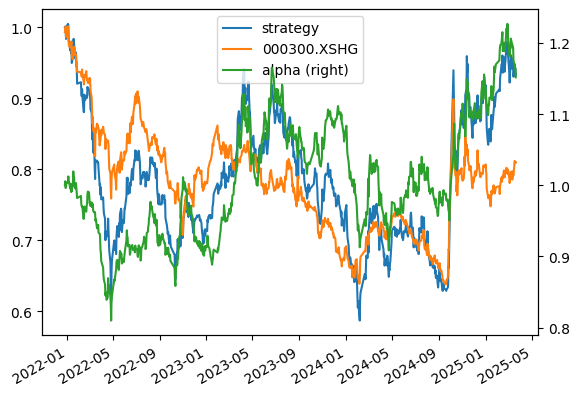

In [133]:
# 信号递延
predict_signal_cum,predict_signal_delay = get_siganl_delay(data_test_total)
# 回测检验
buy_list = (predict_signal_cum != 0).astype(int)
df_wight = buy_list.div(buy_list.sum(axis = 1),axis = 0).replace(0,np.nan)
df_wight = df_wight.shift(1).dropna(how = 'all')
account_result = backtest(df_wight,5)
performance_cumnet,result = get_performance_analysis(account_result,index_item)
performance_cumnet.plot(secondary_y='alpha')
result

#### xgboost

In [134]:
def best_estimetor_XGBoost(data_train_input,fatcors):
    precision_postive_cv_clf = pd.DataFrame()
    for max_depth_level in tqdm([3,6,9]):
        for eta_level in [0.8,1,1.2]:
            for gamma_level in [0.001, 0.01, 0.1]:
                clf = XGBClassifier(max_depth=max_depth_level,eta = eta_level,gamma = gamma_level)
                precision_postive_cv = 0
                for i in range(1,6):
                    data_train = data_train_input[data_train_input.label != i]
                    data_validation = data_train_input[data_train_input.label == i]
                    x_train = data_train.loc[:,fatcors]
                    y_train = data_train.loc[:,'target']
                    x_val = data_validation.loc[:,fatcors]
                    y_val = data_validation.loc[:,'target']
                    clf.fit(x_train,y_train)
                    y_hat = clf.predict(x_val)                                          # 训练模型
                    martrix = confusion_matrix(y_val, y_hat)
                    metric = martrix[1,1] / martrix[:,1].sum()                          # 精确率 预测是涨结果真的涨了
                    # metric = (martrix[1,1] + martrix[0,0]) / martrix.sum().sum()      # 准确率 预测是涨结果真的涨了
                    precision_postive_cv += metric
                temp = pd.DataFrame([max_depth_level,eta_level,gamma_level,precision_postive_cv/5],index = ['max_depth_level','eta_level','gamma_level','precision_postive_cv'])
                precision_postive_cv_clf = pd.concat([precision_postive_cv_clf,temp],axis = 1)
    return precision_postive_cv_clf


In [ ]:
model_name = 'xgb'
data_test_total = pd.DataFrame()

for i in tqdm(re_train_days):            # 测试5期
    # 训练开始/结束时间
    train_start = pd.Timestamp(get_previous_trading_date(i,(pre_gap + ret_gap)))
    train_end = pd.Timestamp(get_previous_trading_date(i,ret_gap))
    # 测试开始/结束时间
    test_start = i
    test_end = pd.Timestamp(get_next_trading_date(i,predict_gap - 1))
    # 训练集数据
    data_train = data.loc[train_start:train_end]
    data_train_x = data_train.loc[:,features]
    data_train_y = data_train.loc[:,'target']
    # 测试集数据
    data_test = data.loc[test_start:test_end]
    data_test_x = data_test.loc[:,features]
    
    # 打标记号_5fold_交叉验证
    date_len = sorted(set(data_train.index.get_level_values(0)))
    fold_length = (len(date_len) - 80)//5
    label = ([1] * fold_length 
            + [0] * 20 
            + [2] * fold_length 
            + [0] * 20 
            + [3] * fold_length 
            + [0] * 20 
            + [4] * fold_length 
            + [0] * 20 
            + [5] * (len(date_len) - 80 - (fold_length * 4))
            )
    for i,j in zip(date_len,label):
        data_train.loc[i,'label'] = j
    
    # 模型训练
    paramter = best_estimetor_XGBoost(data_train,features).T.sort_values(by ='precision_postive_cv',ascending = False).iloc[0].to_dict()
    print(i,paramter)
    # 模型输出
    clf = XGBClassifier(max_depth=int(paramter['max_depth_level']),
                        eta = paramter['eta_level'],
                        gamma = paramter['gamma_level'])


    # 预测结果输出
    y_hat = clf.fit(data_train_x,data_train_y).predict(data_test_x)
    data_test['predict'] = y_hat
    data_test_total = pd.concat([data_test_total,data_test[['predict']]],axis = 0)

data_test_total.to_pickle(os.path.join(file_path, f'data/data_test_total_{model_name}_all.pkl'))

100%|██████████| 3/3 [00:34<00:00, 11.41s/it]


2021-12-17 00:00:00 {'max_depth_level': 9.0, 'eta_level': 1.0, 'gamma_level': 0.1, 'precision_postive_cv': 0.46776453673716184}


100%|██████████| 3/3 [00:34<00:00, 11.61s/it]]


2022-03-21 00:00:00 {'max_depth_level': 9.0, 'eta_level': 1.0, 'gamma_level': 0.001, 'precision_postive_cv': 0.46555564394588067}


100%|██████████| 3/3 [00:34<00:00, 11.42s/it]]


2022-06-21 00:00:00 {'max_depth_level': 9.0, 'eta_level': 1.2, 'gamma_level': 0.001, 'precision_postive_cv': 0.4701368984218409}


100%|██████████| 3/3 [00:36<00:00, 12.31s/it]]


2022-09-14 00:00:00 {'max_depth_level': 6.0, 'eta_level': 0.8, 'gamma_level': 0.01, 'precision_postive_cv': 0.4771201661475851}


 29%|██▊       | 4/14 [02:22<05:58, 35.84s/it]

In [ ]:
model_name = 'xgb'
data_test_total = pd.read_pickle(os.path.join(file_path, f'data/data_test_total_{model_name}_all.pkl'))

In [ ]:
# 获取标的收益
def get_bar(df):
    """
    :param df: 买入队列 -> dataframe/unstack
    :return ret: 基准的逐日收益 -> dataframe
    """
    start_date = get_previous_trading_date(df.index.min(),1).strftime('%F')
    end_date = df.index.max().strftime('%F')
    stock_list = df.columns.tolist()
    price_open = pd.read_pickle('./300/300_stock_open.pkl')
    price_open = price_open.loc[start_date:end_date]
    price_open = price_open[[i for i in price_open.columns if i in stock_list]]
    
    return price_open

# 回测框架
def backtest(df_weight, change_n = 20, cash = 10000 * 1000, tax = 0.0005, other_tax = 0.0001, commission = 0.0002, min_fee = 5, cash_interest_yield = 0.02):

    # 基础参数
    
    inital_cash = cash                                                                                                            # 起始资金
    stock_holding_num_hist = 0                                                                                                    # 初始化持仓       
    buy_cost = other_tax + commission                                                                                             # 买入交易成本
    sell_cost = tax + other_tax + commission                                                                                      # 卖出交易成本
    cash_interest_daily = (1 + cash_interest_yield) ** (1/252) - 1                                                                # 现金账户利息(日)
    account = pd.DataFrame(index = df_weight.index,columns=['total_account_asset','holding_market_cap','cash_account'])           # 账户信息存储
    price_open = get_bar(df_weight)                                                                                               # 获取开盘价格数据
    stock_round_lot = pd.Series(dict([(i,100) for i in df_weight.columns.tolist()]))                         # 标的最小买入数量
    change_day = sorted(set(df_weight.index.tolist()[::change_n] + [df_weight.index[-1]]))                                        # 调仓日期

    # 滚动计算
    for i in tqdm(range(0,len(change_day)-1)):
        start_date = change_day[i]
        end_date = change_day[i+1]

        # 获取给定权重
        df_weight_temp = df_weight.loc[start_date].dropna()
        stock_list_temp = df_weight_temp.index.tolist()
        # 计算个股持股数量 = 向下取整(给定权重 * 可用资金 // 最小买入股数) * 最小买入股数
        stock_holding_num = ((df_weight_temp 
                            * cash 
                            / (price_open.loc[start_date,stock_list_temp] * (1 + sell_cost))        # 预留交易费用
                            // stock_round_lot.loc[stock_list_temp]) 
                            * stock_round_lot.loc[stock_list_temp])

        # 仓位变动      
        ## 防止相减为空 & 剔除无变动
        stock_holding_num_change = stock_holding_num.sub(stock_holding_num_hist,fill_value = 0).replace(0,np.nan).dropna()
        # 获取期间价格
        price_open_temp = price_open.loc[start_date:end_date,stock_holding_num_change.index]           # 引入完整券池
        
        # 计算交易成本 (可设置万一免五)
        def calc_fee(x,min_fee):
            if x < 0:
                fee_temp = -1 * x * sell_cost                                                                                       # 印花税 + 过户费等 + 佣金
            else:
                fee_temp = x * buy_cost                                                                                             # 过户费等 + 佣金
            # 最低交易成本限制
            if fee_temp > min_fee:
                return fee_temp
            else:
                return min_fee

        transaction_costs = ((price_open_temp.loc[start_date] 
                            * stock_holding_num_change)).apply(lambda x: calc_fee(x,min_fee)).sum()
        # 计算期间市值 （交易手续费在现金账户计提）
        holding_market_cap = (price_open_temp * stock_holding_num).sum(axis =1)
        cash_account = cash - transaction_costs - holding_market_cap.loc[start_date]
        cash_account = pd.Series([cash_account * ((1 + cash_interest_daily)**(i+1)) for i in range(0,len(holding_market_cap))],
                                index = holding_market_cap.index)
        total_account_asset = holding_market_cap + cash_account
        
        # 将当前持仓存入 
        stock_holding_num_hist = stock_holding_num
        # 下一期期初可用资金
        cash = total_account_asset.loc[end_date]

        account.loc[start_date:end_date,'total_account_asset'] = round(total_account_asset,2)
        account.loc[start_date:end_date,'holding_market_cap'] = round(holding_market_cap,2)
        account.loc[start_date:end_date,'cash_account'] = round(cash_account,2)

    account.loc[pd.to_datetime(get_previous_trading_date(account.index.min(),1))] = [inital_cash,0,inital_cash]
    account = account.sort_index()
    
    return account



def get_benchmark(df,benchmark,benchmark_type):
    """
    :param df: 买入队列 -> dataframe/unstack
    :param benchmark: 基准指数 -> str
    :return ret: 基准的逐日收益 -> dataframe
    """
    start_date = get_previous_trading_date(df.index.min(),1).strftime('%F')
    end_date = df.index.max().strftime('%F')
    if benchmark_type == 'mcw':
        price_open = pd.read_pickle('./300/300_open.pkl')
        price_open = price_open.loc[start_date:end_date]
    else:
        index_fix = INDEX_FIX(start_date,end_date,benchmark)
        stock_list = index_fix.columns.tolist()
        price_open = get_price(stock_list,start_date,end_date,fields=['open']).open.unstack('order_book_id')
        price_open = price_open.pct_change().mask(~index_fix).mean(axis = 1)
        price_open = (1 + price_open).cumprod().to_frame(benchmark)
    
    return price_open



# 回测绩效指标绘制
def get_performance_analysis(account_result,benchmark_index,benchmark_type = 'mcw'):
    
    rf = 0.03

    # 加入基准    
    performance = pd.concat([account_result['total_account_asset'].to_frame('strategy'),
                             get_benchmark(account_result,benchmark_index,benchmark_type)],axis = 1)
    performance_net = performance.pct_change().dropna(how = 'all')                                # 清算至当日开盘
    performance_cumnet = (1 + performance_net).cumprod()
    performance_cumnet['alpha'] = performance_cumnet['strategy']/performance_cumnet[benchmark_index]
    performance_cumnet = performance_cumnet.fillna(1)

    # 指标计算
    performance_pct = performance_cumnet.pct_change().dropna()

    # 策略收益
    strategy_name,benchmark_name,alpha_name = performance_cumnet.columns.tolist() 
    Strategy_Final_Return = performance_cumnet[strategy_name].iloc[-1] - 1

    # 策略年化收益
    Strategy_Annualized_Return_EAR = (1 + Strategy_Final_Return) ** (252/len(performance_cumnet)) - 1

    # 基准收益
    Benchmark_Final_Return = performance_cumnet[benchmark_name].iloc[-1] - 1

    # 基准年化收益
    Benchmark_Annualized_Return_EAR = (1 + Benchmark_Final_Return) ** (252/len(performance_cumnet)) - 1

    # alpha 
    ols_result = sm.OLS(performance_pct[strategy_name] * 252 - rf, sm.add_constant(performance_pct[benchmark_name] * 252 - rf)).fit()
    Alpha = ols_result.params[0]

    # beta
    Beta = ols_result.params[1]

    # beta_2 = np.cov(performance_pct[strategy_name],performance_pct[benchmark_name])[0,1]/performance_pct[benchmark_name].var()
    # 波动率
    Strategy_Volatility = performance_pct[strategy_name].std() * np.sqrt(252)

    # 夏普
    Strategy_Sharpe = (Strategy_Annualized_Return_EAR - rf)/Strategy_Volatility

    # 下行波动率
    strategy_ret = performance_pct[strategy_name]
    Strategy_Down_Volatility = strategy_ret[strategy_ret < 0].std() * np.sqrt(252)

    # sortino
    Sortino = (Strategy_Annualized_Return_EAR - rf)/Strategy_Down_Volatility
    
    # 跟踪误差
    Tracking_Error = (performance_pct[strategy_name] - performance_pct[benchmark_name]).std() * np.sqrt(252)

    # 信息比率
    Information_Ratio = (Strategy_Annualized_Return_EAR - Benchmark_Annualized_Return_EAR)/Tracking_Error

    # 最大回测
    i = np.argmax((np.maximum.accumulate(performance_cumnet[strategy_name]) 
                    - performance_cumnet[strategy_name])
                    /np.maximum.accumulate(performance_cumnet[strategy_name]))
    j = np.argmax(performance_cumnet[strategy_name][:i])
    Max_Drawdown = (1-performance_cumnet[strategy_name][i]/performance_cumnet[strategy_name][j])

    # 卡玛比率
    Calmar = (Strategy_Annualized_Return_EAR)/Max_Drawdown

    # 超额收益
    Alpha_Final_Return = performance_cumnet[alpha_name].iloc[-1] - 1

    # 超额年化收益
    Alpha_Annualized_Return_EAR = (1 + Alpha_Final_Return) ** (252/len(performance_cumnet)) - 1

    # 超额波动率
    Alpha_Volatility = performance_pct[alpha_name].std() * np.sqrt(252)

    # 超额夏普
    Alpha_Sharpe = (Alpha_Annualized_Return_EAR - rf)/Alpha_Volatility

    # 超额最大回测
    i = np.argmax((np.maximum.accumulate(performance_cumnet[alpha_name]) 
                    - performance_cumnet[alpha_name])
                    /np.maximum.accumulate(performance_cumnet[alpha_name]))
    j = np.argmax(performance_cumnet[alpha_name][:i])
    Alpha_Max_Drawdown = (1-performance_cumnet[alpha_name][i]/performance_cumnet[alpha_name][j])

    # 胜率
    performance_pct['win'] = performance_pct[alpha_name] > 0
    Win_Ratio = performance_pct['win'].value_counts().loc[True] / len(performance_pct)

    # 盈亏比
    profit_lose = performance_pct.groupby('win')[alpha_name].mean()
    Profit_Lose_Ratio = abs(profit_lose[True]/profit_lose[False])
    

    result = {
        '策略累计收益':round(Strategy_Final_Return,4),
        '策略年化收益': round(Strategy_Annualized_Return_EAR,4),
        '基准累计收益':round(Benchmark_Final_Return,4),
        '基准年化收益': round(Benchmark_Annualized_Return_EAR,4),
        '阿尔法':round(Alpha,4),
        '贝塔':round(Beta,4),
        '波动率':round(Strategy_Volatility,4),
        '夏普比率':round(Strategy_Sharpe,4),
        '下行波动率':round(Strategy_Down_Volatility,4),
        '索提诺比率':round(Sortino,4),
        '跟踪误差':round(Tracking_Error,4),
        '信息比率':round(Information_Ratio,4),
        '最大回撤':round(Max_Drawdown,4),
        '卡玛比率': round(Calmar,4),
        '超额累计收益':round(Alpha_Final_Return,4),
        '超额年化收益': round(Alpha_Annualized_Return_EAR,4),
        '超额波动率':round(Alpha_Volatility,4),
        '超额夏普':round(Alpha_Sharpe,4),
        '超额最大回测':round(Alpha_Max_Drawdown,4),
        '胜率':round(Win_Ratio,4),
        '盈亏比':round(Profit_Lose_Ratio,4)
    }
    

    return performance_cumnet,result


100%|██████████| 156/156 [00:00<00:00, 765.94it/s]


{'策略累计收益': np.float64(0.4404),
 '策略年化收益': np.float64(0.125),
 '基准累计收益': np.float64(-0.1902),
 '基准年化收益': np.float64(-0.0658),
 '阿尔法': np.float64(0.1769),
 '贝塔': np.float64(0.883),
 '波动率': np.float64(0.2178),
 '夏普比率': np.float64(0.436),
 '下行波动率': np.float64(0.126),
 '索提诺比率': np.float64(0.7534),
 '跟踪误差': np.float64(0.1182),
 '信息比率': np.float64(1.6135),
 '最大回撤': np.float64(0.229),
 '卡玛比率': np.float64(0.5457),
 '超额累计收益': np.float64(0.7786),
 '超额年化收益': np.float64(0.2042),
 '超额波动率': np.float64(0.1178),
 '超额夏普': np.float64(1.4793),
 '超额最大回测': np.float64(0.1129),
 '胜率': np.float64(0.5474),
 '盈亏比': np.float64(1.0954)}

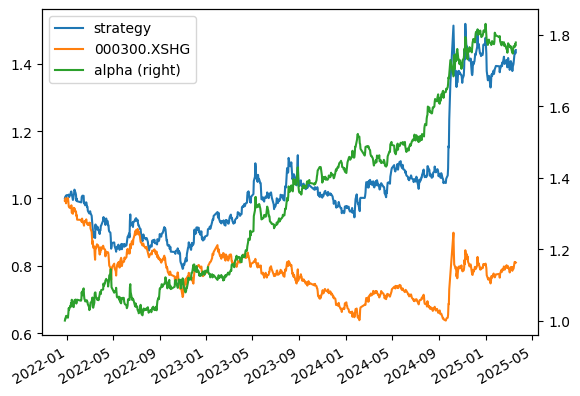

In [ ]:
# 信号递延
predict_signal_cum,predict_signal_delay = get_siganl_delay(data_test_total)
# 回测检验
buy_list = (predict_signal_cum != 0).astype(int)
df_wight = buy_list.div(buy_list.sum(axis = 1),axis = 0).replace(0,np.nan)
df_wight = df_wight.shift(1).dropna(how = 'all')
account_result = backtest(df_wight,5)
performance_cumnet,result = get_performance_analysis(account_result,index_item)
performance_cumnet.plot(secondary_y='alpha')
result

#### KNN

In [ ]:
def best_estimetor_knn(data_train_input,fatcors):
    precision_postive_cv_clf = pd.DataFrame()
    for n_neighbors_num in tqdm(range(3,12,4)):
        clf = KNeighborsClassifier(n_neighbors=n_neighbors_num,n_jobs = -2)         
        precision_postive_cv = 0
        for i in range(1,6):
            data_train = data_train_input[data_train_input.label != i]
            data_validation = data_train_input[data_train_input.label == i]
            x_train = data_train.loc[:,fatcors]
            y_train = data_train.loc[:,'target']
            x_val = data_validation.loc[:,fatcors]
            y_val = data_validation.loc[:,'target']
            clf.fit(x_train,y_train)
            y_hat = clf.predict(x_val)                                          # 训练模型
            martrix = confusion_matrix(y_val, y_hat)
            metric = martrix[1,1] / martrix[:,1].sum()                          # 精确率 预测是涨结果真的涨了
            # metric = (martrix[1,1] + martrix[0,0]) / martrix.sum().sum()      # 准确率 预测是涨结果真的涨了
            precision_postive_cv += metric
        temp = pd.DataFrame([n_neighbors_num,precision_postive_cv/5],index = ['n_neighbors_num','precision_postive_cv'])
        precision_postive_cv_clf = pd.concat([precision_postive_cv_clf,temp],axis = 1)
    return precision_postive_cv_clf

In [21]:
model_name = 'knn'
data_test_total = pd.DataFrame()

for i in tqdm(re_train_days):            # 测试5期
    # 训练开始/结束时间
    train_start = pd.Timestamp(get_previous_trading_date(i,(pre_gap + ret_gap)))
    train_end = pd.Timestamp(get_previous_trading_date(i,ret_gap))
    # 测试开始/结束时间
    test_start = i
    test_end = pd.Timestamp(get_next_trading_date(i,predict_gap - 1))
    # 训练集数据
    data_train = data.loc[train_start:train_end]
    data_train_x = data_train.loc[:,features]
    data_train_y = data_train.loc[:,'target']
    # 测试集数据
    data_test = data.loc[test_start:test_end]
    data_test_x = data_test.loc[:,features]
    
    # 打标记号_5fold_交叉验证
    date_len = sorted(set(data_train.index.get_level_values(0)))
    fold_length = (len(date_len) - 80)//5
    label = ([1] * fold_length 
            + [0] * 20 
            + [2] * fold_length 
            + [0] * 20 
            + [3] * fold_length 
            + [0] * 20 
            + [4] * fold_length 
            + [0] * 20 
            + [5] * (len(date_len) - 80 - (fold_length * 4))
            )
    for i,j in zip(date_len,label):
        data_train.loc[i,'label'] = j
    
    # 模型训练
    paramter = best_estimetor_knn(data_train,features).T.sort_values(by ='precision_postive_cv',ascending = False).iloc[0].to_dict()
    print(i,paramter)
    # 模型输出
    clf = KNeighborsClassifier(n_neighbors=int(paramter['n_neighbors_num']),
                               n_jobs = -2)  

    # 预测结果输出
    y_hat = clf.fit(data_train_x,data_train_y).predict(data_test_x)
    data_test['predict'] = y_hat
    data_test_total = pd.concat([data_test_total,data_test[['predict']]],axis = 0)


create_dir_not_exist('./data')
data_test_total.to_pickle(f'./data/data_test_total_{model_name}_all.pkl')

  0%|          | 0/14 [00:00<?, ?it/s]


NameError: name 'get_previous_trading_date' is not defined

In [ ]:
model_name = 'knn'
data_test_total = pd.read_pickle(f'./data/data_test_total_{model_name}_all.pkl')

In [ ]:
# 信号递延
predict_signal_cum,predict_signal_delay = get_siganl_delay(data_test_total)
# 回测检验
buy_list = (predict_signal_cum != 0).astype(int)
df_wight = buy_list.div(buy_list.sum(axis = 1),axis = 0).replace(0,np.nan)
df_wight = df_wight.shift(1).dropna(how = 'all')
account_result = backtest(df_wight,5)
performance_cumnet,result = get_performance_analysis(account_result,index_item)
performance_cumnet.plot(secondary_y='alpha')
result

### 3 模型融合

In [ ]:
model_name = 'vote'
data_test_total = pd.DataFrame()

# 模型训练结果记录
rf_record = {}
xgb_record = {}
knn_record = {}

for i in tqdm(re_train_days):            # 测试5期
    # 训练开始/结束时间
    train_start = pd.Timestamp(get_previous_trading_date(i,(pre_gap + ret_gap)))
    train_end = pd.Timestamp(get_previous_trading_date(i,ret_gap))
    # 测试开始/结束时间
    test_start = i
    test_end = pd.Timestamp(get_next_trading_date(i,predict_gap - 1))
    # 训练集数据
    data_train = data.loc[train_start:train_end]
    data_train_x = data_train.loc[:,features]
    data_train_y = data_train.loc[:,'target']
    # 测试集数据
    data_test = data.loc[test_start:test_end]
    data_test_x = data_test.loc[:,features]
    
    # 打标记号_5fold_交叉验证
    date_len = sorted(set(data_train.index.get_level_values(0)))
    fold_length = (len(date_len) - 80)//5
    label = ([1] * fold_length 
            + [0] * 20 
            + [2] * fold_length 
            + [0] * 20 
            + [3] * fold_length 
            + [0] * 20 
            + [4] * fold_length 
            + [0] * 20 
            + [5] * (len(date_len) - 80 - (fold_length * 4))
            )
    for i,j in zip(date_len,label):
        data_train.loc[i,'label'] = j
    
    # 模型训练
    print(i)
    record_date = test_start.strftime('%F')
    
    paramter_rf = best_estimetor_RandomForestClassifier(data_train,features).T.sort_values(by ='precision_postive_cv',ascending = False).iloc[0].to_dict()
    print('rf',paramter_rf)
    rf_record[record_date] = paramter_rf

    paramter_xgb = best_estimetor_XGBoost(data_train,features).T.sort_values(by ='precision_postive_cv',ascending = False).iloc[0].to_dict()
    print('xgb',paramter_xgb)
    xgb_record[record_date] = paramter_xgb
    
    paramter_knn = best_estimetor_knn(data_train,features).T.sort_values(by ='precision_postive_cv',ascending = False).iloc[0].to_dict()
    print('knn',paramter_knn)
    knn_record[record_date] = paramter_knn
    
    # 模型输出
    clf_rf = RandomForestClassifier(n_estimators = 10,
                                    criterion = 'gini',
                                    max_features = int(paramter_rf['max_features']),
                                    max_depth = int(paramter_rf['max_depth']),
                                    class_weight = 'balanced',
                                    ccp_alpha = paramter_rf['ccp_alpha'],
                                    random_state = 0)
    
    clf_xgb = XGBClassifier(max_depth = int(paramter_xgb['max_depth_level']),
                            eta = paramter_xgb['eta_level'],
                            gamma = paramter_xgb['gamma_level'])
    
    clf_knn = KNeighborsClassifier(n_neighbors=int(paramter_knn['n_neighbors_num']),
                                   n_jobs = -2)    

    # 投票法
    estimators_voting1 =[('DecisionTreeClassifier',clf_rf),
                        ('RandomForestClassifier',clf_xgb),
                        ('KNeighborsClassifier',clf_knn)] 
    
    clf_voting = VotingClassifier(estimators_voting1,voting = 'soft',n_jobs = -2)


    # 预测结果输出
    y_hat = clf_voting.fit(data_train_x,data_train_y).predict(data_test_x)
    data_test['predict'] = y_hat
    data_test_total = pd.concat([data_test_total,data_test[['predict']]],axis = 0)


create_dir_not_exist('./data')
data_test_total.to_pickle(f'./data/data_test_total_{model_name}.pkl')

In [ ]:
pickle.dump(rf_record,open('./data/rf_record.pkl','wb'))
pickle.dump(xgb_record,open('./data/xgb_record.pkl','wb'))
pickle.dump(knn_record,open('./data/knn_record.pkl','wb'))

In [3]:
model_name = 'vote'
data_test_total = pd.read_pickle(f'./data/data_test_total_{model_name}_all.pkl')

FileNotFoundError: [Errno 2] No such file or directory: './data/data_test_total_vote_all.pkl'

In [ ]:
# 信号递延
predict_signal_cum,predict_signal_delay = get_siganl_delay(data_test_total)
# 回测检验
buy_list = (predict_signal_cum != 0).astype(int)
df_wight = buy_list.div(buy_list.sum(axis = 1),axis = 0).replace(0,np.nan)
df_wight = df_wight.shift(1).dropna(how = 'all')
account_result = backtest(df_wight,5)
performance_cumnet,result = get_performance_analysis(account_result,index_item)
performance_cumnet.plot(secondary_y='alpha')
result

#### 精确率排名

In [ ]:
model_name = 'vote_metric_rank'
data_test_total = pd.DataFrame()

# 模型训练结果记录
rf_record = pd.read_pickle('./data/rf_record.pkl')
xgb_record = pd.read_pickle('./data/xgb_record.pkl')
knn_record = pd.read_pickle('./data/knn_record.pkl')

for i in tqdm(re_train_days):            # 测试5期
    # 训练开始/结束时间
    train_start = pd.Timestamp(get_previous_trading_date(i,(pre_gap + ret_gap)))
    train_end = pd.Timestamp(get_previous_trading_date(i,ret_gap))
    # 测试开始/结束时间
    test_start = i
    test_end = pd.Timestamp(get_next_trading_date(i,predict_gap - 1))
    # 训练集数据
    data_train = data.loc[train_start:train_end]
    data_train_x = data_train.loc[:,features]
    data_train_y = data_train.loc[:,'target']
    # 测试集数据
    data_test = data.loc[test_start:test_end]
    data_test_x = data_test.loc[:,features]
    
    # 打标记号_5fold_交叉验证
    date_len = sorted(set(data_train.index.get_level_values(0)))
    fold_length = (len(date_len) - 80)//5
    label = ([1] * fold_length 
            + [0] * 20 
            + [2] * fold_length 
            + [0] * 20 
            + [3] * fold_length 
            + [0] * 20 
            + [4] * fold_length 
            + [0] * 20 
            + [5] * (len(date_len) - 80 - (fold_length * 4))
            )
    for i,j in zip(date_len,label):
        data_train.loc[i,'label'] = j
    
    # 模型训练
    print(i)
    record_date = test_start.strftime('%F')
    
    paramter_rf = rf_record[record_date]
    paramter_xgb = xgb_record[record_date]
    paramter_knn = knn_record[record_date]

    # paramter_rf = best_estimetor_RandomForestClassifier(data_train,features).T.sort_values(by ='precision_postive_cv',ascending = False).iloc[0].to_dict()
    # print('rf',paramter_rf)
    # rf_record[record_date] = paramter_rf

    # paramter_xgb = best_estimetor_XGBoost(data_train,features).T.sort_values(by ='precision_postive_cv',ascending = False).iloc[0].to_dict()
    # print('xgb',paramter_xgb)
    # xgb_record[record_date] = paramter_xgb
    
    # paramter_knn = best_estimetor_knn(data_train,features).T.sort_values(by ='precision_postive_cv',ascending = False).iloc[0].to_dict()
    # print('knn',paramter_knn)
    # knn_record[record_date] = paramter_knn
    
    # 模型输出
    clf_rf = RandomForestClassifier(n_estimators = 10,
                                    criterion = 'gini',
                                    max_features = int(paramter_rf['max_features']),
                                    max_depth = int(paramter_rf['max_depth']),
                                    class_weight = 'balanced',
                                    ccp_alpha = paramter_rf['ccp_alpha'],
                                    random_state = 0)
    
    clf_xgb = XGBClassifier(max_depth = int(paramter_xgb['max_depth_level']),
                            eta = paramter_xgb['eta_level'],
                            gamma = paramter_xgb['gamma_level'])
    
    clf_knn = KNeighborsClassifier(n_neighbors=int(paramter_knn['n_neighbors_num']),
                                   n_jobs = -2)    

    # 投票法
    estimators_voting1 =[('DecisionTreeClassifier',clf_rf),
                        ('RandomForestClassifier',clf_xgb),
                        ('KNeighborsClassifier',clf_knn)] 
    
    weight_series = pd.Series({'weight_clf_rf':paramter_rf['precision_postive_cv'],
                            'weight_clf_xgb':paramter_xgb['precision_postive_cv'],
                            'weight_clf_knn':paramter_knn['precision_postive_cv']})
    
    weight_series_rank = weight_series.rank(ascending = True)
    print(weight_series_rank.to_dict())

    clf_voting = VotingClassifier(estimators_voting1,
                                voting = 'soft',
                                weights = [weight_series_rank['weight_clf_rf'],
                                            weight_series_rank['weight_clf_xgb'],
                                            weight_series_rank['weight_clf_knn']],
                                n_jobs = -2)


    # 预测结果输出
    y_hat = clf_voting.fit(data_train_x,data_train_y).predict(data_test_x)
    data_test['predict'] = y_hat
    data_test_total = pd.concat([data_test_total,data_test[['predict']]],axis = 0)


create_dir_not_exist('./data')
data_test_total.to_pickle(f'./data/data_test_total_{model_name}.pkl')

In [ ]:
model_name = 'vote_metric_rank'
data_test_total = pd.read_pickle(f'./data/data_test_total_{model_name}.pkl')

# 信号递延
predict_signal_cum,predict_signal_delay = get_siganl_delay(data_test_total)
# 回测检验
buy_list = (predict_signal_cum != 0).astype(int)
df_wight = buy_list.div(buy_list.sum(axis = 1),axis = 0).replace(0,np.nan)
df_wight = df_wight.shift(1).dropna(how = 'all')
account_result = backtest(df_wight,5)
performance_cumnet,result = get_performance_analysis(account_result,index_item)
performance_cumnet.plot(secondary_y='alpha')
result